## RTI Center for Data Science - Exercise 1

*In part 1, I took the brute force approach by not caring about the number of predictors or the redundancy (correlations) between them, and throwing a ton of different classification models at the data. Here, I'm going to try to take a more refined approach with some feature engineering to reduce my number of predictors.*

*In part 2, I started a more elegant approach by converting categorical predictors into numerical predictors, and found that I could achieve nearly as high testing accuracy with only 8 features (86.4%) as the 100+ feature model from part 1 (87.0%). Here, I'm going to polish the model off by incorporating the last few categorical predictors that can't be easily converted into numerical representations.*

Links to the full instructions and SQLite database can be found [here](https://github.com/rtidatascience/data-scientist-exercise01).

Briefly, the goal is to take some census data and use it to predict the probability that a person makes more or less than $50,000/year.

First, I'll import some of our go-to libraries, as well as *sqlite3*, which I'll use to connect to our SQLite database. I'll import other libraries later as we need them.

The goal here is to "flatten" the database into a single table using various IDs to pull relevant textual information from various supporting tables. There are many ways to do this, but I'm going to leverage pandas' *read_sql_query* function, which helpfully takes a SQL query and outputs it into Python as a DataFrame. I'm going to retain everything in our _records_ table (_SELECT r.*_), and just take the textual information from all of our other tables.

Then, I'll look at the correlation structure (which will ignore the text inputs). I'll pay special attention to which variables are correlated with the target variables, *over_50k*.

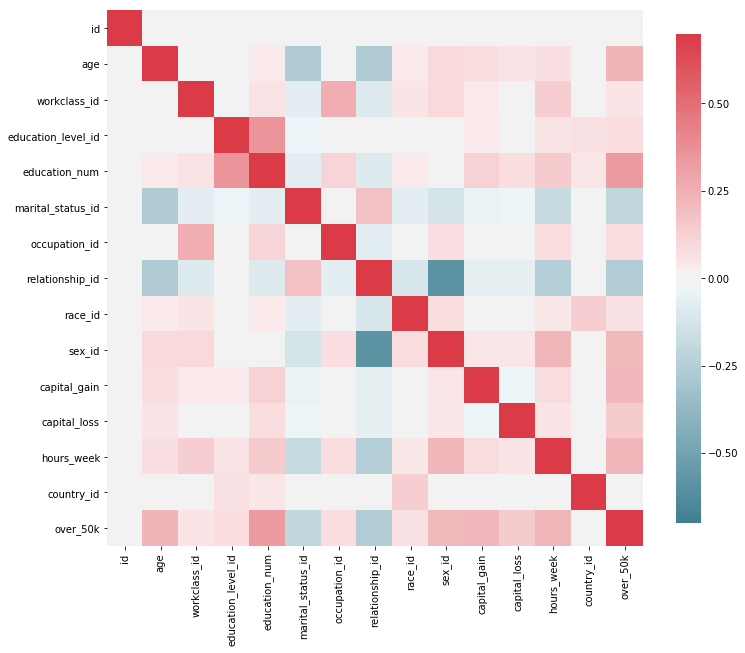

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('./exercise01.sqlite')
records = pd.read_sql_query("""SELECT r.*, w.name AS workclass, e.name AS education_level, 
                        m.name AS marital_status, o.name AS occupation, re.name AS relationship, 
                        ra.name AS race, s.name AS sex, c.name AS country                   
    FROM records AS r
    INNER JOIN workclasses AS w ON r.workclass_id=w.id
    INNER JOIN education_levels AS e ON r.education_level_id=e.id
    INNER JOIN marital_statuses AS m ON r.marital_status_id=m.id
    INNER JOIN occupations AS o ON r.occupation_id=o.id
    INNER JOIN relationships AS re ON r.relationship_id=re.id
    INNER JOIN races AS ra ON r.race_id=ra.id
    INNER JOIN sexes AS s ON r.sex_id=s.id
    INNER JOIN countries AS c ON r.country_id=c.id
    """, conn)

conn.close()

corr = records.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr,
    vmin = -0.7, vmax = 0.7,
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax
)

### Using theory and data to select variables
There are some variables that I can immediately decide whether to include or exclude from the dataset. For instance, any correlations between *id* and our target variable are spurious, since I don't want the order of data entry to matter. On the other hand, I would be highly surprised if variables like *age*, *race_id*, *sex_id*, and *hours_week* were not important for accurate prediction. In general, categorical variables are more of a hassle to keep, because they need to be dummy-coded (which can increase the number of predictors by a large number), so let's also look at the number of options within each categorical variable.

| Keep | Drop | TBD |
|---|---|---|
|age|id|workclass_id|
|race_id||education_level_id|
|sex_id||education_num|
|hours_week||marital_status_id|
|||occupation_id|
|||relationship_id|
|||capital_gain|
|||capital_loss|
|||country_id|


In [2]:
# start building new dataset
data = pd.DataFrame()
data['over_50k'] = records.over_50k
data['age'] = records.age
data['sex'] = records.sex_id # keep as numerical because there are only two options
data['hours_week'] = records.hours_week

# we can simplify race by grouping white/asian
white = records.race=='White'
asian = records.race=='Asian-Pac-Islander'
data['race'] = np.bitwise_or(white,asian).astype(int)

# we can also simplify marital status by grouping Married-AF-spouse and Married-civ-spouse
AF = records.marital_status=='Married-AF-spouse'
civ = records.marital_status=='Married-civ-spouse'
data['marital_status'] = np.bitwise_or(AF,civ).astype(int)

# add in capital gains and losses
data['capital_gain'] = records.capital_gain
data['capital_loss'] = records.capital_loss

[1.27861969]


/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


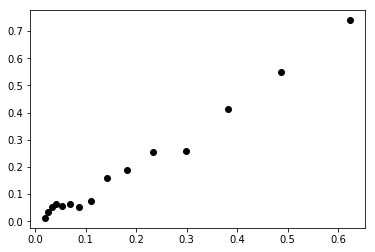

In [3]:
# transforming education_num
mean_target = records.groupby(['education_num']).mean()['over_50k']
ln_y = np.log(mean_target)
x = np.asarray(mean_target.index.tolist())

from sklearn.linear_model import LinearRegression
mdl = LinearRegression()
mdl.fit(x.reshape(-1,1),ln_y)
print(np.exp(mdl.coef_))

education_num = records.education_num
education_num.loc[education_num==16] = 15
data['education_num'] = np.exp(mdl.intercept_)*np.exp(mdl.coef_)**education_num

# check that transformation worked
ed_nums = data['education_num'].unique()
ed_nums.sort()
plt.plot(ed_nums, mean_target[0:-1], 'ko')

Here is where the current DataFrame stands, as of the end of part 2.

| Keep | Drop | TBD |
|---|---|---|
|age|id|workclass_id|
|race_id|education_level_id|relationship_id|
|sex_id||occupation_id|
|hours_week||country_id|
|marital_status_id|||
|capital_gain|||
|capital_loss|||
|education_num|||

There are three more primary tasks that I'd like to do, and will be adding in gradually. First, I'm going to look through my continuous features and see if any of them might benefit from a transformation (similar to what I did to *education_num*). Second, I'm going to work on ways to incorporate my TBD features, all of which should add some predictive power. And third, I'm going to use something like LDA or an SVM to see if there are any detectable differences between observations that are and are not predicted correctly, which may provide insight about where the current model is lacking and can be improved.

### Transforming continuous features

Text(0,0.5,'p(over_50k)')

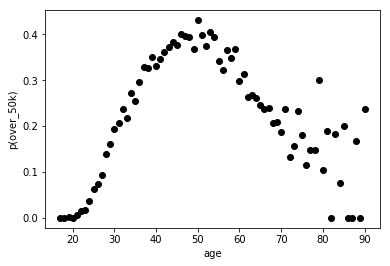

In [4]:
# race_id, sex_id, and marital_status_id are already binary, so no need to transform them
# education_num has already been transformed
# that leaves age, hours_week, capital_gain, and capital_loss to investigate

# age
mean_target = data.groupby(['age']).mean()['over_50k']
plt.plot(mean_target.index, mean_target,'ko')
plt.xlabel('age')
plt.ylabel('p(over_50k)')


Text(0,0.5,'frequency')

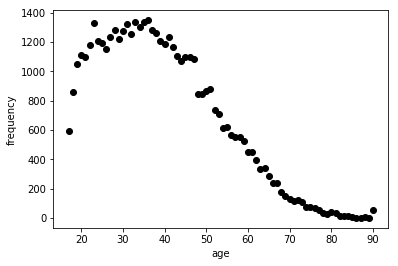

In [5]:
# wow! is the extra variability for older individuals truly in there or an artifact of smaller sample sizes
age_counts = data.age.value_counts()
plt.plot(age_counts.index, age_counts, 'ko')
plt.xlabel('age')
plt.ylabel('frequency')

Int64Index([50], dtype='int64', name='age')


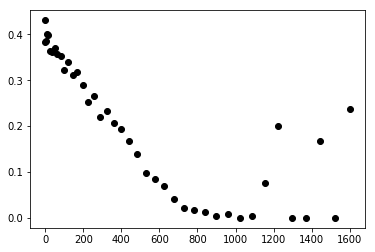

In [6]:
# okay, it looks like the extra variability may just be due to smaller sample sizes at older ages, so let's ignore it.
# our curve up above looks like an unnormalized Gaussian distribution with maybe a slight positive linear slope.
# so i'm going to leave in our regular 'age' variable but also include a deviance, which is the square of the
# difference between age and the "best age"

age = data.age
best_age = mean_target.index[mean_target==max(mean_target)].astype(int)
print(best_age)

pd_age = pd.DataFrame()

pd_age['age'] = age
pd_age['dev'] = (age - best_age)**2
pd_age['over_50k'] = data.over_50k
dev_target = pd_age.groupby(['dev']).mean()['over_50k']

plt.plot(dev_target.index, dev_target, 'ko')


Text(0,0.5,'p(over_50k)')

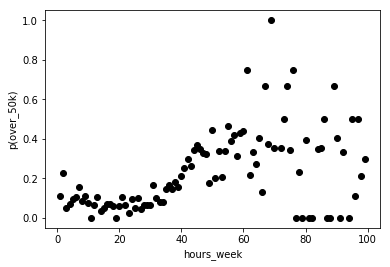

In [7]:
data['age_dev'] = pd_age['dev']

# hours_week is next
mean_target = data.groupby(['hours_week']).mean()['over_50k']
plt.plot(mean_target.index, mean_target,'ko')
plt.xlabel('hours_week')
plt.ylabel('p(over_50k)')

In [8]:
# that is quite a complicated function, but it's mostly linear (?) so i'm going to leave it as is
# next up: capital_gain

print(data.capital_gain.value_counts())

0        44807
15024      513
7688       410
7298       364
99999      244
3103       152
5178       146
5013       117
4386       108
8614        82
3325        81
2174        74
10520       64
4650        63
27828       58
4064        54
594         52
3137        51
20051       49
14084       49
3908        42
6849        42
13550       42
2829        42
1055        37
4787        35
3411        34
14344       34
3464        33
2597        31
         ...  
9562         5
2538         5
6723         5
2050         5
11678        4
2936         4
7896         4
4931         4
4687         4
2961         4
1455         4
1424         4
3432         4
2062         3
2993         3
2009         3
6360         3
41310        3
6097         2
5060         2
18481        2
1264         2
7978         2
7262         1
1731         1
2387         1
22040        1
6612         1
1111         1
1639         1
Name: capital_gain, Length: 123, dtype: int64


In [9]:
# the vast majority people have no capital_gain listed, so i'm going to exclude those people from this analysis and
# include a binary variable to say whether or not one is listed
data['cap_gain_present'] = data.capital_gain>0

capital_gain
0     0.000000
1     0.000000
2     0.425150
3     0.000000
4     0.000000
5     0.509728
6     0.513158
7     0.806452
8     0.983796
9     0.957854
10    1.000000
11    0.992754
12    0.964427
Name: over_50k, dtype: float64


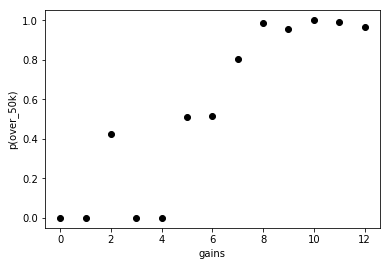

In [10]:
# for those who do have one listed, let's examine
sub_data = data[data.capital_gain>0]

logged_gains = np.log(sub_data.capital_gain)
binned_logged_gains = pd.qcut(logged_gains, 16, labels=False, duplicates='drop')

mean_target = sub_data.groupby(binned_logged_gains).mean()['over_50k']
plt.plot(mean_target.index, mean_target,'ko')
plt.xlabel('gains')
plt.ylabel('p(over_50k)')
print(mean_target)

capital_loss
0    0.204348
1    0.186957
2    0.003731
3    0.360976
4    1.000000
5    0.940789
6    0.891228
7    0.000000
8    0.175299
9    0.790244
Name: over_50k, dtype: float64


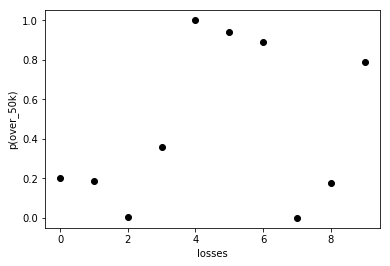

In [11]:
# store the bin here
data['cap_gain_bin'] = binned_logged_gains
data['cap_gain_bin'] = data['cap_gain_bin'].fillna(0)

# do same thing for capital_losses
data['cap_loss_present'] = data.capital_loss>0

sub_data = data[data.capital_loss>0]

logged_losses = np.log(sub_data.capital_loss)
binned_logged_losses = pd.qcut(logged_losses, 10, labels=False, duplicates='drop')

mean_target = sub_data.groupby(binned_logged_losses).mean()['over_50k']
plt.plot(mean_target.index, mean_target,'ko')
plt.xlabel('losses')
plt.ylabel('p(over_50k)')
print(mean_target)

Okay! I've transformed age by adding a "deviation" variable (although I'm retaining my raw "age" variable as well. I've logged and binned capital_gain, and added binary variables to list whether capital gains and losses are listed or are 0. I'm keeping hours_week and capital_loss as is, because there wasn't a straightforward and logical transformation to make in either case. Now I just need to remove my original capital_gains variable (because it's been replaced by the logged and bin version), and I should end up with a total of 11 features at this stage (+1 target variable).

In [12]:
data = data.drop(['capital_gain'],axis=1)
print(data.columns)
data.shape

Index(['over_50k', 'age', 'sex', 'hours_week', 'race', 'marital_status',
       'capital_loss', 'education_num', 'age_dev', 'cap_gain_present',
       'cap_gain_bin', 'cap_loss_present'],
      dtype='object')


(48842, 12)

### Adding in remaining categorical features

In [13]:
# start with workclass(_id)
print(records.groupby(['workclass']).mean()['over_50k'].sort_values())

workclass
Never-worked        0.000000
?                   0.094677
Without-pay         0.095238
Private             0.217867
State-gov           0.267542
Self-emp-not-inc    0.278871
Local-gov           0.295599
Federal-gov         0.391760
Self-emp-inc        0.553392
Name: over_50k, dtype: float64


In [14]:
# combine ? and Without-pay into Without-pay
# combine State-gov and Self-emp-not-inc into State-gov

workclass = records.workclass
workclass.loc[workclass=='?'] = 'Without-pay'
workclass.loc[workclass=='Self-emp-not-inc'] = 'State-gov'

workclass_d = pd.get_dummies(workclass, prefix='WC')
workclass_d.sum()

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WC_Federal-gov      1432
WC_Local-gov        3136
WC_Never-worked       10
WC_Private         33906
WC_Self-emp-inc     1695
WC_State-gov        5843
WC_Without-pay      2820
dtype: int64

In [15]:
# relationship(_id)
print(records.groupby(['relationship']).mean()['over_50k'].sort_values())

relationship
Own-child         0.014642
Other-relative    0.034529
Unmarried         0.060293
Not-in-family     0.101407
Husband           0.448671
Wife              0.468897
Name: over_50k, dtype: float64


In [16]:
# combine husband and wife into spouse
relationship = records.relationship
relationship.loc[relationship=='Husband'] = 'Spouse'
relationship.loc[relationship=='Wife'] = 'Spouse'

relationship_d = pd.get_dummies(relationship, prefix='RS')
relationship_d.sum()

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


RS_Not-in-family     12583
RS_Other-relative     1506
RS_Own-child          7581
RS_Spouse            22047
RS_Unmarried          5125
dtype: int64

In [17]:
# occupation(_id)
print(records.groupby(['occupation']).mean()['over_50k'].sort_values())

occupation
Priv-house-serv      0.012397
Other-service        0.041438
Handlers-cleaners    0.066602
?                    0.094340
Farming-fishing      0.116107
Machine-op-inspct    0.123097
Adm-clerical         0.136874
Transport-moving     0.204246
Craft-repair         0.226276
Sales                0.267987
Tech-support         0.290456
Protective-serv      0.313327
Armed-Forces         0.333333
Prof-specialty       0.451069
Exec-managerial      0.477818
Name: over_50k, dtype: float64


In [18]:
# i'm going to try leaving occupation intact for now
occupation = records.occupation
occupation_d = pd.get_dummies(occupation, prefix='O')

In [19]:
# what about country?
print(records.groupby(['country']).mean()['over_50k'].sort_values())
print(records.country.value_counts())

country
Holand-Netherlands            0.000000
Guatemala                     0.034091
Outlying-US(Guam-USVI-etc)    0.043478
Columbia                      0.047059
Dominican-Republic            0.048544
Mexico                        0.049422
Nicaragua                     0.061224
El-Salvador                   0.070968
Trinadad&Tobago               0.074074
Vietnam                       0.081395
Peru                          0.086957
Laos                          0.086957
Honduras                      0.100000
Puerto-Rico                   0.108696
Haiti                         0.120000
Ecuador                       0.133333
Jamaica                       0.141509
Scotland                      0.142857
Thailand                      0.166667
South                         0.173913
Portugal                      0.179104
Poland                        0.195402
United-States                 0.243977
Cuba                          0.246377
?                             0.256709
Hong             

In [20]:
# the vast majority of people are from the US
# sort into US vs developing vs developed vs unknown
# NOTE: i'm just guessing at these! i have no idea!
Country_Dictionary = {
'United-States': 'US',
 'Cuba': 'Developed',
 'Jamaica': 'Developing',
 'India': 'Developed',
 '?': 'Unknown',
 'Mexico': 'Developing',
 'South': 'Developing',
 'Puerto-Rico': 'Developing',
 'Honduras': 'Developing',
 'England': 'Developed',
 'Canada': 'Developed',
 'Germany': 'Developed',
 'Iran': 'Developed',
 'Philippines': 'Developing',
 'Italy': 'Developed',
 'Poland': 'Developed',
 'Columbia': 'Developing',
 'Cambodia': 'Developing',
 'Thailand': 'Developing',
 'Ecuador': 'Developing',
 'Laos': 'Developing',
 'Taiwan': 'Developing',
 'Haiti': 'Developing',
 'Portugal': 'Developed',
 'Dominican-Republic': 'Developing',
 'El-Salvador': 'Developing',
 'France': 'Developed',
 'Guatemala': 'Developing',
 'China': 'Developed',
 'Japan': 'Developed',
 'Yugoslavia': 'Developed',
 'Peru': 'Developing',
 'Outlying-US(Guam-USVI-etc)': 'Developing',
 'Scotland': 'Developed',
 'Trinadad&Tobago': 'Developing',
 'Greece': 'Developed',
 'Nicaragua': 'Developing',
 'Vietnam': 'Developing',
 'Hong': 'Developed',
 'Ireland': 'Developed',
 'Hungary': 'Developed',
 'Holand-Netherlands': 'Developed'
}

In [21]:
countries = records.country
countries = countries.map(Country_Dictionary)
countries_d = pd.get_dummies(countries, prefix='C')

### Put everything together!
Now I'll combine my dummy-coded variables with my continuous variables, split into training and testing sets, and start running some models!

In [22]:
all_data = pd.concat([data,workclass_d,relationship_d,occupation_d,countries_d],axis=1)
all_data.head()

,over_50k,age,sex,hours_week,race,marital_status,capital_loss,education_num,age_dev,cap_gain_present,...,O_Priv-house-serv,O_Prof-specialty,O_Protective-serv,O_Sales,O_Tech-support,O_Transport-moving,C_Developed,C_Developing,C_US,C_Unknown
0,0,39,2,40,1,0,0,0.380885,121,True,...,0,0,0,0,0,0,0,0,1,0
1,0,50,2,13,1,1,0,0.380885,0,False,...,0,0,0,0,0,0,0,0,1,0
2,0,38,2,40,1,0,0,0.142505,144,False,...,0,0,0,0,0,0,0,0,1,0
3,0,53,2,40,0,1,0,0.087166,9,False,...,0,0,0,0,0,0,0,0,1,0
4,0,28,1,40,0,1,0,0.380885,484,False,...,0,1,0,0,0,0,1,0,0,0


In [23]:
from sklearn.model_selection import train_test_split

test = all_data['over_50k']
train = all_data.drop(['over_50k'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(train, test, train_size=0.7)

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


I'll start with two simple models, logistic regression, and a decision tree.

In [24]:
from sklearn.linear_model import LogisticRegression
mdl = LogisticRegression()
mdl.fit(train_X,train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8571762847699552 0.8556609568006551


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

mdl = DecisionTreeClassifier()

# use GridSearchCV to search for some tree parameters
# max_depth: 5,8,10,15,20,None
# min_samples_leaf: 1,2,3,5,10

param_grid = {'max_depth':[5,8,10,15,20,None],
             'min_samples_leaf':[1,2,3,5,10]}

grid_search = GridSearchCV(mdl, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(train_X,train_y)

print(grid_search.best_score_)
print(grid_search.best_params_)

0.8577905174178829
{'max_depth': 8, 'min_samples_leaf': 5}


In [26]:
max_depth = grid_search.best_params_.get('max_depth')
min_samples_leaf = grid_search.best_params_.get('min_samples_leaf')

mdl = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf)
mdl.fit(train_X,train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8611541723946299 0.8586637548624855


### Can we predict which observations are and aren't well predicted?

In [27]:
target_1 = test_y==1
target_0 = test_y==0

data_1 = test_X[target_1]
data_0 = test_X[target_0]
print(data_1.shape, data_0.shape)

(3520, 42) (11133, 42)


In [28]:
correct_1 = mdl.predict(data_1)==1
error_1 = mdl.predict(data_1)==0

correct_0 = mdl.predict(data_0)==0
error_0 = mdl.predict(data_0)==1

print(correct_1.mean(), correct_0.mean())

0.5659090909090909 0.9512260846133118


In [29]:
# we are really good at correctly identifying individuals who don't make >50k
# but a lot less good at correctly identifying individuals who do

# is there any difference between individuals who are correctly identified as making >50k and those who aren't?
# since this is just investigative (and not changing our final model yet), no need to split into train/test sets

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

mdl = LinearDiscriminantAnalysis()
mdl.fit(data_1,correct_1)
print(mdl.score(data_1,correct_1))

0.9110795454545455


/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0,0,'education_num'),
 Text(0,0,'WC_Never-worked'),
 Text(0,0,'O_Armed-Forces'),
 Text(0,0,'O_Priv-house-serv')]

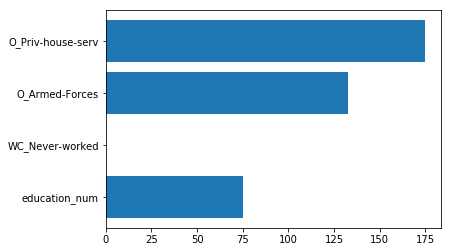

In [30]:
coefs = mdl.coef_.flatten()
stds = data_1.std()
ratio = np.divide(coefs,stds)
inds = abs(ratio)>20

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.barh(np.arange(0,sum(inds))+1, abs(ratio[inds]))
ax.set_yticks(np.arange(0,sum(inds))+1)
ax.set_yticklabels(data_1.columns[inds])

### Work in progress...